In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# load data
path #path of the file
df = pd.read_csv(path)

df.head()

,ID,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [74]:
# check the null values
df.isnull().sum()

ID                  0
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [75]:
# drop null values
df.dropna(subset=['Description','CustomerID'],inplace=True)
# check the null values
df.isnull().sum()

ID             0
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [76]:
# only take one country
df = df[df.Country== 'United Kingdom']

# create new colums returns
df['Return']=df.InvoiceNo.str.contains('C')
# store the result in purchase 
df['Purchase'] = np.where(df["Return"]==True,0,1)
df.head()

,ID,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Return,Purchase
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,False,1
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,False,1
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,False,1
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,False,1
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,False,1


In [77]:
# create new dataframe customer
customers = pd.DataFrame({'CustomerID': df['CustomerID'].unique()},dtype=int)
customers.head()

,CustomerID
0,17850
1,13047
2,13748
3,15100
4,15291


In [78]:
# calculate the recency
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Recency'] = pd.to_datetime("2011-12-10") - (df['InvoiceDate'])
df.head()

,ID,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Return,Purchase,Recency
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,1,373 days 15:34:00
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,1,373 days 15:34:00
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,1,373 days 15:34:00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,1,373 days 15:34:00
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,1,373 days 15:34:00


In [79]:
# remove the time factor
df.Recency = df.Recency.dt.days

# purchase equal to one 
temp = df[df['Purchase']==1]

# customers latest purchase day
recency=temp.groupby(by='CustomerID',as_index=False).min()
customers=customers.merge(recency[['CustomerID','Recency']],on='CustomerID')
customers.head()

,CustomerID,Recency
0,17850,372
1,13047,31
2,13748,95
3,15100,333
4,15291,25


In [80]:
# Removing invoice number duplicates

temp_1=df[['CustomerID','InvoiceNo','Purchase']]
temp_1.drop_duplicates(subset=['InvoiceNo'],inplace=True)

C:\Users\91916\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [81]:
# calculte the frequency of the purchases
annual_invoice=temp_1.groupby(by='CustomerID',as_index=False).sum()
annual_invoice.rename(columns={'Purchase':'Frequency'},inplace=True)


In [82]:
# merge in the Customer
customers=customers.merge(annual_invoice,on='CustomerID')
print(customers.shape)

(3921, 3)


In [83]:
# Create amount and groupby based on customer id
df['Amount']=df['Quantity'] * df['UnitPrice']
annual_sales=df.groupby(by='CustomerID',as_index=False).sum()
annual_sales.rename(columns={'Amount':'monetary'},inplace=True)

# added in the customer dataframe
customers=customers.merge(annual_sales[['CustomerID','monetary']],on='CustomerID')
customers.head()

,CustomerID,Recency,Frequency,monetary
0,17850,372,34,5288.63
1,13047,31,10,3079.10
2,13748,95,5,948.25
3,15100,333,3,635.10
4,15291,25,15,4596.51


In [84]:
# negative monetory removed because they returned the object 
customers['monetary']=np.where(customers['monetary']<0,0,customers['monetary'])    

# log transform
customers['Recency_log']=np.log(customers['Recency']+0.1) # there values equals to zero to avoid log zero increase by +0.1
customers['Frequency_log']=np.log(customers['Frequency']+0.1)
customers['Monetary_log']=np.log(customers['monetary']+0.1)
customers.head()

,CustomerID,Recency,Frequency,monetary,Recency_log,Frequency_log,Monetary_log
0,17850,372,34,5288.63,5.919163,3.529297,8.573333
1,13047,31,10,3079.10,3.437208,2.312535,8.032425
2,13748,95,5,948.25,4.554929,1.629241,6.854724
3,15100,333,3,635.10,5.808443,1.131402,6.453940
4,15291,25,15,4596.51,3.222868,2.714695,8.433074


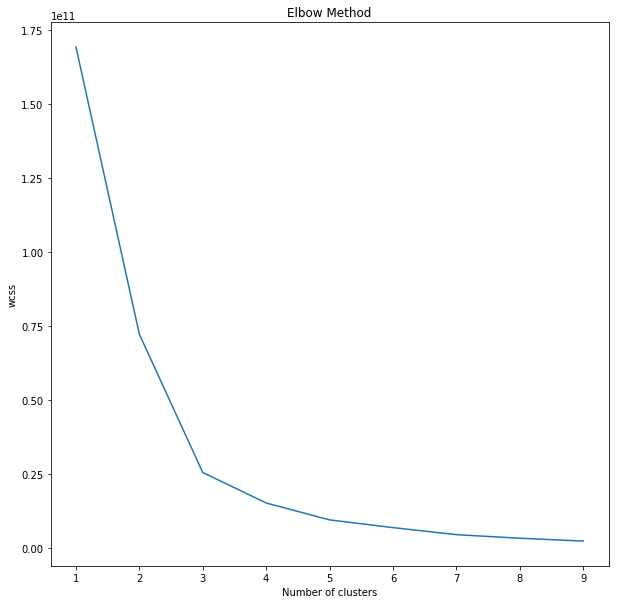

In [85]:
# import packages
from sklearn.cluster import KMeans

# Code starts here

# Empty list for storing WCSS across all values of k
dist = []

# Iterate from 1-9
for i in range(1,10):
    # Initialize KMeans algorithm
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    # Fit on data
    km.fit(customers.iloc[:,1:7])
    # Append WCSS to list storing WCSS
    dist.append(km.inertia_)

# Initialize figure
plt.figure(figsize=(10,10))

# Line plot # clusters on X-axis and WCSS on Y-axis 
plt.plot(range(1,10),dist)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

# Code ends here

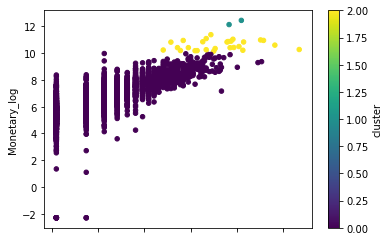

In [92]:
# initialize KMeans object
cluster = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)

# create 'cluster' column
customers['cluster'] = cluster.fit_predict(customers.iloc[:,1:7])

# plot the cluster

customers.plot.scatter(x= 'Frequency_log', y= 'Monetary_log', c='cluster', colormap='viridis')
plt.show()

# Code ends here